<a href="https://colab.research.google.com/github/dbamman/nlp23/blob/main/HW1/HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 1: Featurized Models for Sentiment Analysis

For this assignment, we provide an implementation of a simple binary classifier that will predict the sentiment of a movie review based on a group of original features -- provided by you! 

Before diving into any code, please read through the associated [PDF](https://github.com/dbamman/nlp23/blob/main/HW1/HW1.pdf) for an overview of the assignment and specific instructions on how to submit.

In [2]:
import sys, argparse
from scipy import sparse
from sklearn import linear_model
from collections import Counter
import numpy as np
import re
from collections import Counter, defaultdict
import operator
import nltk
import csv
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
from pandas import option_context

In [3]:
!python -m nltk.downloader punkt

/usr/lib/python3.8/runpy.py:127: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### Intro: Gather Data + Create Classifier

#### Gather Data

Let's download the data we'll use for training and development, and also the data we'll make predictions with.

In [4]:
# Get data
!wget https://raw.githubusercontent.com/dbamman/nlp23/main/HW1/train.txt
!wget https://raw.githubusercontent.com/dbamman/nlp23/main/HW1/dev.txt
!wget https://raw.githubusercontent.com/dbamman/nlp23/main/HW1/test.txt

--2023-01-31 05:01:06--  https://raw.githubusercontent.com/dbamman/nlp23/main/HW1/train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1322055 (1.3M) [text/plain]
Saving to: ‘train.txt’

train.txt           100%[===================>]   1.26M  --.-KB/s    in 0.009s  

2023-01-31 05:01:06 (148 MB/s) - ‘train.txt’ saved [1322055/1322055]

--2023-01-31 05:01:06--  https://raw.githubusercontent.com/dbamman/nlp23/main/HW1/dev.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1309909 (1.2M) [text/plain]
Saving to: ‘dev.txt’

dev.t

In [5]:
trainingFile = "train.txt"
evaluationFile = "dev.txt"
testFile = "test.txt"

#### Define Classifier class

Next, we've created a Binary Classifier. This class will let us learn the traits associated with positive and negatively classed movie reviews in order to make predictions on our test set.

In [6]:
######################################################################
## Do not edit this block of code.
## This defines the classification class which
## loads the data and sets up the model.
######################################################################

class Classifier:

    def __init__(self, feature_method, L2_regularization_strength=1.0, min_feature_count=1):
        self.feature_vocab = {}
        self.feature_method = feature_method
        self.log_reg = None
        self.L2_regularization_strength=L2_regularization_strength
        self.min_feature_count=min_feature_count

        self.trainX, self.trainY, self.trainOrig = self.process(trainingFile, training=True)
        self.devX, self.devY, self.devOrig = self.process(evaluationFile, training=False)
        self.testX, _, self.testOrig = self.process(testFile, training=False)

    # Read data from file
    def load_data(self, filename):
        data = []
        with open(filename, encoding="utf8") as file:
            for line in file:
                cols = line.split("\t")
                idd = cols[0]
                label = cols[1]
                text = cols[2]

                data.append((idd, label, text))
                
        return data

    # Featurize entire dataset
    def featurize(self, data):
        featurized_data = []
        for idd, label, text in data:
            feats = self.feature_method(text)
            featurized_data.append((label, feats))
        return featurized_data

    # Read dataset and returned featurized representation as sparse matrix + label array
    def process(self, dataFile, training = False):
        original_data = self.load_data(dataFile)
        data = self.featurize(original_data)

        if training:
            fid = 0
            feature_doc_count = Counter()
            for label, feats in data:
                for feat in feats:
                    feature_doc_count[feat]+= 1

            for feat in feature_doc_count:
                if feature_doc_count[feat] >= self.min_feature_count:
                    self.feature_vocab[feat] = fid
                    fid += 1

        F = len(self.feature_vocab)
        D = len(data)
        X = sparse.dok_matrix((D, F))
        Y = [None]*D
        for idx, (label, feats) in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    X[idx, self.feature_vocab[feat]] = feats[feat]
            Y[idx] = label

        return X, Y, original_data

    def load_test(self, dataFile):
        data = self.load_data(dataFile)
        data = self.featurize(data)

        F = len(self.feature_vocab)
        D = len(data)
        X = sparse.dok_matrix((D, F))
        Y = [None]*D
        for idx, (data_id, feats) in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    X[idx, self.feature_vocab[feat]] = feats[feat]
            Y[idx] = data_id

        return X, Y

    # Train model and evaluate on held-out data
    def evaluate(self):
        (D,F) = self.trainX.shape
        self.log_reg = linear_model.LogisticRegression(C = self.L2_regularization_strength, max_iter=1000)
        self.log_reg.fit(self.trainX, self.trainY)
        training_accuracy = self.log_reg.score(self.trainX, self.trainY)
        development_accuracy = self.log_reg.score(self.devX, self.devY)
        print("Method: %s, Features: %s, Train accuracy: %.3f, Dev accuracy: %.3f" % (self.feature_method.__name__, F, training_accuracy, development_accuracy))


    # Predict labels for new data
    def predict(self):
        predX = self.log_reg.predict(self.testX)

        with open("%s_%s" % (self.feature_method.__name__, "predictions.csv"), "w", encoding="utf8") as out:
            writer=csv.writer(out)
            writer.writerow(["Id", "Expected"])
            for idx, data_id in enumerate(self.testX):
                writer.writerow([self.testOrig[idx][0], predX[idx]])
        out.close()


    def printWeights(self, n=10):

        reverse_vocab=[None]*len(self.log_reg.coef_[0])
        for k in self.feature_vocab:
            reverse_vocab[self.feature_vocab[k]]=k

        # binary
        if len(self.log_reg.classes_) == 2:
              weights=self.log_reg.coef_[0]

              cat=self.log_reg.classes_[1]
              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

              cat=self.log_reg.classes_[0]
              for feature, weight in list(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1)))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

        # multiclass
        else:
          for i, cat in enumerate(self.log_reg.classes_):

              weights=self.log_reg.coef_[i]

              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

            

#### Simple Classifier example

Let's create an initial classifier based on a really simple feature using a dictionary: 

* if the abstract contains the words "love" or "like", the `contains_positive_word` feature will fire, and 
* if it contains either "hate" or "dislike", the `contains_negative_word` will fire.  

Note how we use `nltk.word_tokenize` to tokenize the text into its discrete words (the documentation for which can be found [here](https://www.nltk.org/api/nltk.tokenize.html)).

In [7]:
def simple_featurize(text):
    feats = {}
    words = nltk.word_tokenize(text)

    for word in words:
        word=word.lower()
        if word == "love" or word == "like":
            feats["contains_positive_word"] = 1
        if word == "hate" or word == "dislike":
            feats["contains_negative_word"] = 1
            
    return feats

Now let's see how that feature performs on the development data. 

Note the `L2_regularization_strength` parameter specifies the strength of the L2 regularizer (values closer to 0 = stronger regularization), and `min_feature_count` specifies how many data points need to contain a feature for it to be passed into the model as a feature. Both are ways to prevent the model from overfitting and achieve higher performance.

In [8]:
simple_classifier = Classifier(simple_featurize, L2_regularization_strength=1.0, min_feature_count=1)
simple_classifier.evaluate()

Method: simple_featurize, Features: 2, Train accuracy: 0.509, Dev accuracy: 0.500


So we've created a classifier. But is its accuracy score any good?  Let's calculate the accuracy of a "majority classifier" to provide some context. This determines the most-represented (majority) class in the training data, and then predicts every test point to be this class.

In [9]:
def majority_class(trainY, devY):
    labelCounts=Counter()
    for label in trainY:
        labelCounts[label]+=1
    majority_class=labelCounts.most_common(1)[0][0]

    correct=0.
    for label in devY:
        if label == majority_class:
            correct+=1
            
    print("Majority class: %s\tDev accuracy: %.3f" % (majority_class, correct/len(devY)))
majority_class(simple_classifier.trainY, simple_classifier.devY)

Majority class: pos	Dev accuracy: 0.500


The feature we created in `simple_featurize`, evidently, doesn't have a whole lot of legs. In the next portion of the homework, you'll be designing a few features of your own in the hopes of achieving the highest accuracy possible.

## Deliverable 1

Your job in this homework is to implement a binary bag-of-words model (i.e., one that assigns a feature value of 1 to each word type that is present in the text); and to brainstorm **3 additional** distinct classes of features, justify why they might help improve the performance *over a bag of words* for this task, implement them in code, and then assess their independent performance on the development data.

To show your work: describe your new features and report their performance in the table below; implement the features in the specified `feature1`, `feature2`, and `feature3` functions, and execute each respective classifier to show its performance.  

|Feature|Why should it work? (50 words each)|Dev set performance|
|---|---|---|
|Bag of words|By counting the apperance of each word in the text, we find the frequency of each work which could be used for its weight.|0.767
|Feature 1|By removing stop words, we reduce the dimensionality of the text, enhance meaning and reduce overfitting by focus on words that actually matter.| 0.780
|Feature 2|Because it captures the relationship between neighboring words in the text and provides better context to individual words.|0.784
|Feature 3|Because it gets rid of all the exttra signs in the text, making it more efficient by reducing the dimensionality.|0.768

Note that it is not required for your features to actually perform well, but your justification for why it *should* perform better than a bag of words should be defensible.  The most creative features (defined as features that few other students use and that are reasonably well-performing) will receive extra credit for this assignment. Consider the type of data you are working with: what do you look for when writing/reading a movie review?

### Implement Bag-of-Words

In [16]:
def bag_of_words(text):
    # Here the `feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.
    
    # BEGIN SOLUTION
    feats = {}

    words = nltk.word_tokenize(text)
    feast = Counter(words)

    return feast
    # END SOLUTION

In [17]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

bow_classifier = Classifier(bag_of_words, L2_regularization_strength=1.0, min_feature_count=1)
bow_classifier.evaluate()

Method: bag_of_words, Features: 23631, Train accuracy: 1.000, Dev accuracy: 0.767


### Implement Original Features

In [39]:
def feature1(text):
    # Here the `feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.
    
    feats = {}
    words = nltk.word_tokenize(text)
    # pos_words = set(("love", "loved", "like", "liked", "great", "awesome", "excellent", "amazing", "excellent", "entertaining", "enjoyable", "fun", "impressive", "wonderful", "fantastic", "best", "fire", "enjoy", "well-done", "enjoyed", "outstanding", "superb", "remarkable", "wonderful", "engaging", "delightful", "pleasing", "captivating", "moving", "touching"))
    # neg_words = set(("hate", "hated", "dislike", "disliked", "boring", "bored", "sleepy", "awful", "bad", "poor", "disappointing", "disappointed", "mediocre", "unimpressive", "lackluster", "dull", "terrible", "worst", "worse", "horrible", "bland", "tedious", "uninteresting", "unengaging", "unenjoyable", "predictable", "uninspired", "unremarkable"))
    # negate = set(('not', 'no', 'non'))
    cleaned = [re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", word) for word in words]
    stop_words = ["the", "on", "of", "with", "a", "an", "and", "in", "to"]

    cleaned = [word for word in cleaned if word not in stop_words]
    feast = Counter(cleaned)

    return feast

In [40]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

classifier1 = Classifier(feature1, L2_regularization_strength=1.0, min_feature_count=1)
classifier1.evaluate()

Method: feature1, Features: 23317, Train accuracy: 1.000, Dev accuracy: 0.780


In [61]:
from scipy.spatial.distance import jaccard
def feature2(text):
    # Here the `feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.
    
    feats = {}
    sents = nltk.sent_tokenize(text)
    
    two_grams = [nltk.ngrams(sent, 4) for sent in sents]    
    flat_list = [ngram for sublist in two_grams for ngram in sublist]

    for ngram in flat_list:
        ngram = "".join(ngram)
        feats[ngram] = feats.get(ngram, 0) + 1
    
    return feats

In [62]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

classifier2 = Classifier(feature2, L2_regularization_strength=1.0, min_feature_count=1)
classifier2.evaluate()

Method: feature2, Features: 70375, Train accuracy: 1.000, Dev accuracy: 0.784


In [81]:
def feature3(text):
    # Here the `feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.
    
    feats = {}
    words = nltk.word_tokenize(text)
    pos_words = set(('6', '7', '8', '9', '10'))
    neg_words = set(('0', '1', '2', '3', '4', '5'))
    cleaned = [re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", word) for word in words]

    for i in range(len(cleaned)):
      if cleaned[i] in pos_words:
        feats[cleaned[i]] = 1 + feats.get(cleaned[i], 0)
      else:
        feats[cleaned[i]] = feats.get(cleaned[i], 0) + 1
            
    return feats

In [82]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

classifier3 = Classifier(feature3, L2_regularization_strength=1.0, min_feature_count=1)
classifier3.evaluate()

Method: feature3, Features: 23326, Train accuracy: 1.000, Dev accuracy: 0.768


## Deliverable 2

The two cells in "Combine your features" will generate a file named `combiner_function_predictions.csv`.

Download this file (using e.g. the file manager on the left panel in Colab) and submit this to GradeScope along with your notebook; the 5 students with the highest performance (revealed after the submission deadline) will receive extra credit for this assignment.

Please do not change the auto-generated filename!

### Combine your features

Next, let's combine any or all the features you have developed into one big model and make predictions on the test data. There is no exact number/threshold we're looking for, accuracy-wise, but the combiner function should *generally* have a higher accuracy than BoW on its own (assuming your features are adding additional information beyond what BoW is adding). 

You don't need to edit the following cell, unless you want to change which features are handed off to the "combined" model.

In [95]:
def combiner_function(text):

    # Here the `all_feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.
    # at the moment, all 4 of: bag of words and your 3 original features are handed off to the combined model
    # update the values within [bag_of_words, feature1, feature2, feature3] to change this.
    
    all_feats={}
    for feature in [bag_of_words, feature1, feature2, feature3]:
        all_feats.update(feature(text))
    return all_feats

In [96]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

big_classifier = Classifier(combiner_function, L2_regularization_strength=1.0, min_feature_count=1)
big_classifier.evaluate()

#generate .csv file with prediction output on test data
big_classifier.predict()

Method: combiner_function, Features: 94645, Train accuracy: 1.000, Dev accuracy: 0.783


## Further Exploration: Interrogating classifiers

Note: No deliverables are in this section; it's optional. Treat this portion as a useful tool for further understanding the features you worked on and how they affter the classifier.

Below you will find several ways in which you can interrogate your model to get ideas on ways to improve its performance.  

1. First, let's look at the confusion matrix of its predictions (where we can compare the true labels with the predicted labels). What kinds of mistakes is it making? (While this is mainly helpful in the context of multiclass classification, we can still see if there's a bias toward predicting a specific class in the binary setting as well). 

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


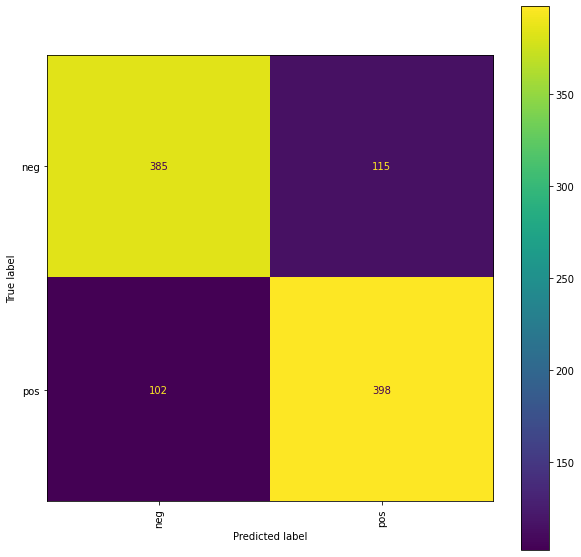

In [97]:
def print_confusion(classifier):
    fig, ax = plt.subplots(figsize=(10,10))
    plot_confusion_matrix(classifier.log_reg, classifier.devX, classifier.devY, ax=ax, xticks_rotation="vertical", values_format="d")
    plt.show()

print_confusion(big_classifier)

2. Next, let's look at the features that are most important for each of the classes (ranked by how strong their corresponding coefficient is). Do the features you are defining help in the ways you think they should?  Do sets of successful features suggests others, or complementary features that may provide a different view on the data?

In [98]:
big_classifier.printWeights(n=25)

pos	0.282	It
pos	0.220	reat
pos	0.197	e an
pos	0.179	 gre
pos	0.177	elle
pos	0.166	fect
pos	0.165	very
pos	0.163	 lov
pos	0.162	zing
pos	0.162	ries
pos	0.160	ne o
pos	0.158	s a 
pos	0.156	njoy
pos	0.152	grea
pos	0.152	ood 
pos	0.150	 per
pos	0.149	I th
pos	0.149	e de
pos	0.149	hey 
pos	0.147	mazi
pos	0.146	ery 
pos	0.146	 you
pos	0.145	azin
pos	0.145	his
pos	0.144	 sim

neg	-0.263	 act
neg	-0.256	wors
neg	-0.228	ould
neg	-0.223	 wor
neg	-0.214	even
neg	-0.214	 bor
neg	-0.204	?
neg	-0.200	 bad
neg	-0.191	here
neg	-0.188	ven 
neg	-0.185	orst
neg	-0.184	ted 
neg	-0.184	less
neg	-0.183	 stu
neg	-0.179	e wh
neg	-0.173	orin
neg	-0.169	t th
neg	-0.169	no
neg	-0.167	wast
neg	-0.165	 was
neg	-0.165	bad
neg	-0.165	worst
neg	-0.162	hing
neg	-0.162	bori
neg	-0.160	 poo



3. Next, let's look at the individual data points that are the hardest to classify correctly. Does it suggest any features you might create to disentangle them?

In [99]:
def analyze(classifier):
    
    probs=classifier.log_reg.predict_proba(classifier.devX)
    predicts=classifier.log_reg.predict(classifier.devX)

    classes={}
    for idx, lab in enumerate(classifier.log_reg.classes_):
        classes[lab]=idx

    mistakes={}
    for i in range(len(probs)):
        if predicts[i] != classifier.devY[i]:
            predicted_lab_idx=classes[predicts[i]]
            mistakes[i]=probs[i][predicted_lab_idx]

    frame=[]
    sorted_x = sorted(mistakes.items(), key=operator.itemgetter(1), reverse=True)
    for k, v in sorted_x:
        idd=classifier.devOrig[k][0]
        text=classifier.devOrig[k][2]
        frame.append([idd, v, classifier.devY[k], predicts[k], text])

    df=pd.DataFrame(frame, columns=["id", "P(predicted class confidence)", "Human label", "Prediction", "Text"])

    with option_context('display.max_colwidth', 400):
        display(df.head(n=20))


In [100]:
analyze(big_classifier)

,id,P(predicted class confidence),Human label,Prediction,Text
0,1436,1.000000,pos,neg,I have never seen such a movie before. I was on the edge of my seat and constantly laughing throughout the entire movie. I never thought such horrible acting existed it was all just too funny. The story behind the movie is decent but the movies scenes fail to portray them. I have never seen such a stupid movie in my life which is why it I think its worth watching. I give this movie 10 out of 1...
1,1182,0.999999,neg,pos,Blank check is one of those kids movies that could have been a great suspense thriller for the kids but instead it's a tired lame home alone ripoff that isn't worth a dime. Quigley is a criminal who just escaped from jail and gets his hidden million dollars from a big score and then we meet Preston a frustrated kid whose room is taken over by his brothers to start a business and obviously dad ...
2,1178,0.999998,pos,neg,"While I do not think this was a perfect 10, I do agree it was way above a 6 which is what it's rated here. No, Brokedown Palace was not perfect and yes it's plot has been done many times before. That doesn't mean it shouldn't be done again if it is done well and I think this movie had some strong moments. The acting of Claire Danes, as already mentioned many times, was flawless as was Kate Bec..."
3,1337,0.999965,pos,neg,FULL OF SPOILERS.This is a pretty fast and enjoyable crime thriller based on Ira Levin's play about two gay playwrights (Caine and Reeve) that plot the murder of one's rich wife (Cannon) to get the property and the insurance. The plot succeeds but Christopher Reeve as the younger and less established of the two writers decides to make a play out of the actual murder -- with only slight changes...
4,1261,0.999944,neg,pos,"NATURAL BORN KILLERS (1994)Cinema Cut: R Director's Cut: NC-17It's an unusual Oliver Stone picture, but when I read he was on drugs during the filming, I needed no further explanation. 'Natural Born Killers' is a risky, mad, all out film-making that we do not get very often; strange, psychotic, artistic pictures.'Natural Born Killers' is basically the story of how two mass killers were popular..."
5,1018,0.999883,pos,neg,"This was surprisingly intelligent for a TV movie, and quite true to my own experience of bulimia. It was actually well-researched, and I can only assume it was written by someone who's gone through a similar experience, because it had all the little details. The characters were quite well-drawn, and the performances by Mare Winningham and Alison Lohman were great. I think what I like most was ..."
6,1138,0.999768,pos,neg,"I find it so amazing that even after all these years, we are STILL talking about this movie! Obviously this movie wasn't THAT bad or else people wouldn't even BOTHER to talk about it. I personally enjoyed this film immensly, and still do! I guess this film isn't for everyone, but it certainly did touch the hearts of many. As for those that think that this film is ""overrated"" or ""over-hyped""......"
7,1787,0.999563,pos,neg,"My roommate had bought this documentary and invited me to watch it with her. She's from China and only heard so much about 9/11 and wanted to know the cold hard truth and she wanted me to tell her more after the documentary. I felt awful watching this documentary, it was like reliving the nightmare and it still brings tears to my eyes.But I'm extremely grateful that I watched this documentary,..."
8,1543,0.999481,pos,neg,"This movie is horrible- in a 'so bad it's good' kind of way.The storyline is rehashed from so many other films of this kind, that I'm not going to even bother describing it. It's a sword/sorcery picture, has a kid hoping to realize how important he is in this world, has a ""nomadic"" adventurer, an evil aide/sorcerer, a princess, a hairy creature....you get the point.The first time I caught this..."
9,1822,0.999466,pos,neg,"Zombi 3 has an interesting history in it's making. Firstly, it is a sequel to F